# <a id="0"></a>Table of Contents

1. [Importing Libraries](#1)     
1. [Importing Datasets](#2) 
1. [EDA & Data Cleaning](#3) 
1. [Addressing Data Imbalance](#4)     
1. [Train-test split](#5)

# <a id="1"><font color = "lightseagreen">1. Importing Libraries<font></a>

In [ ]:
# Basic Libraries
import pandas as pd
import numpy as np

# Path and Data Management
import os
import shutil
import re

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Image Manipulation/Processing
from PIL import Image

# Pseudo-randomizers
import random
from random import sample

# Settings
import warnings

In [ ]:
# Setting session parameters
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# <a id="2"><font color = "lightseagreen">2. Importing Dataset<font></a>

<font color = "dimgray">The dataset consists of 4 folders, with the data provided being the images separated in 4 folders corresponding to 4 classes. To access the image data, paths to the files must be set up.<font>

In [ ]:
# Defining data paths. Note that all the files were initially in the same folders per category and since most of them will 
# be used for training the model, they were saved in the "train" folder. Later on they will be sampled to create the validation and test sets
data_path = os.path.join(os.getcwd(), "data")

cloudy_train = os.path.join(data_path, "train/cloudy")
desert_train = os.path.join(data_path, "train/desert")
forest_train = os.path.join(data_path, "train/green_area")
water_train = os.path.join(data_path, "train/water")

# Defining validation directories to be created
cloudy_valid = os.path.join(data_path, "valid/cloudy")
desert_valid = os.path.join(data_path, "valid/desert")
forest_valid = os.path.join(data_path, "valid/green_area")
water_valid = os.path.join(data_path, "valid/water")

# Defining test directory to be created
imbalanced_test_dir = os.path.join(data_path, "test/test")  # prefix imbalanced will make sense later along the script

In [ ]:
# Storing image names in lists
cloudy_img_lst = os.listdir(cloudy_train)
desert_img_lst = os.listdir(desert_train)
forest_img_lst = os.listdir(forest_train)
water_img_lst = os.listdir(water_train)

In [ ]:
# This function will make sure that directories will not be overwritten during file operations
def fix_valid_test_dirs(validation_dir_list, test_dir):
    # fixing validation directories
    for val_dir in validation_dir_list:
        os.makedirs(val_dir, exist_ok=True)
    # fixing test directory
    os.makedirs(test_dir, exist_ok=True)

fix_valid_test_dirs([cloudy_valid, desert_valid, forest_valid, water_valid], imbalanced_test_dir)

Image Dataset Preview 



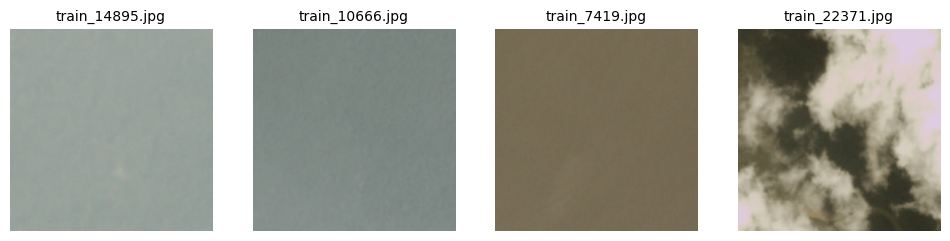

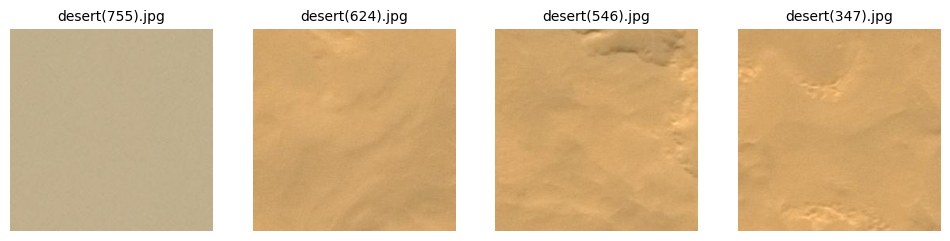

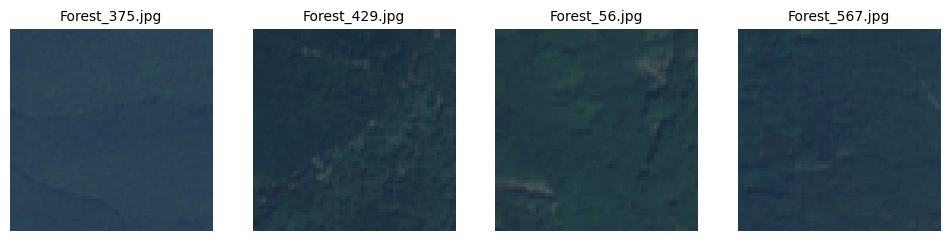

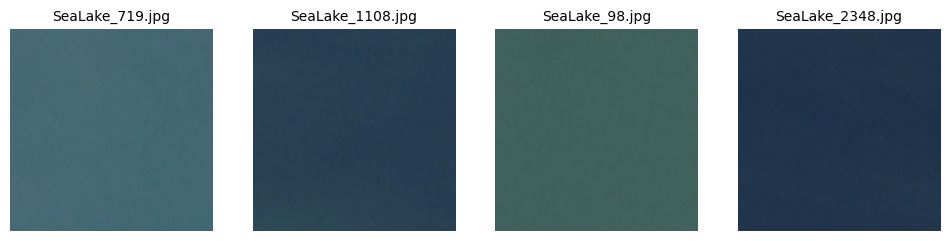

In [8]:
list_path_list = [(cloudy_img_lst, cloudy_train),
                  (desert_img_lst, desert_train),
                  (forest_img_lst, forest_train),
                  (water_img_lst, water_train)]

print("Image Dataset Preview", "\n")

# Code inspired by @isi_mube (Github)
for pair in list_path_list:
    fig, ax = plt.subplots(1, 4, figsize=(12, 12))
    for i, image in enumerate(np.random.choice(pair[0], 4)):
        img = Image.open(os.path.join(pair[1], image))
        ax[i].imshow(img)
        ax[i].axis('off') 
        ax[i].set_title(f"{image}", fontsize = 10)
    plt.show()

# <a id="3"><font color = "lightseagreen">3. EDA & Data Cleaning<font></a>

In [ ]:
# On examination of the folders' contents, it was made clear that the cloudy images all have the prefix "train", but since the
# models will be trained, validated and tested using samples of all images and for the avoidance of confusion, renaming them seems only right
print("Cloudy image title check:", sample(cloudy_img_lst, 5), "\n")
print("Desert image title check:", sample(desert_img_lst, 5), "\n")
print("Green area title prefix check:", sample(forest_img_lst, 5), "\n")
print("Water image title check:", sample(water_img_lst, 5))

In [ ]:
# Double-checking
pattern1 = r"train_(\d+)"  # pattern provided by ChatGPT
pattern2 = r"cloudy_(\d+)"
num_match1 = 0
num_match2 = 0

for filename in cloudy_img_lst:
    match1 = re.match(pattern1, random.choice(cloudy_img_lst))
    match2 = re.match(pattern2, random.choice(cloudy_img_lst))
    if match1:
        num_match1 += 1
    elif match2:
        num_match2 += 1
    else:
        print("no match", filename)

print("num train", num_match1)
print("num cloudy", num_match2)

In [ ]:
# Finally changing names of files in direcrory
for filename in cloudy_img_lst:
    match = re.match(pattern1, filename)
    if match:
        num = match.group(1)  # keeping number part intact
        new_filename = f"cloudy_{num}.jpg"  # defining new filename
        os.rename(os.path.join(cloudy_train + "/" + filename), (cloudy_train + "/" + new_filename))
    else:
        continue

# Redefining cloudy image list with new file names
cloudy_img_lst = os.listdir(cloudy_train)

# Double-checking
print("Cloudy image title check:", sample(cloudy_img_lst, 5), "\n")

In [ ]:
# Also changing the name of "SeaLake" images to "water" to avoid confusion
pattern1 = r"SeaLake_(\d+)"

for filename in water_img_lst:
    match = re.match(pattern1, filename)
    if match:
        num = match.group(1)
        new_filename = f"water_{num}.jpg"
        os.rename(os.path.join(water_train + "/" + filename), (water_train + "/" + new_filename))
    else:
        continue

water_img_lst = os.listdir(water_train)

print("Water image title check:", sample(water_img_lst, 5), "\n")

In [6]:
print("count_cloudy:", len(cloudy_img_lst))
print("count_desert:", len(desert_img_lst))
print("count_forest:", len(forest_img_lst))
print("count_water:", len(water_img_lst), "\n")
print("count_all:", len(cloudy_img_lst + desert_img_lst + forest_img_lst + water_img_lst))

count_cloudy: 1500
count_desert: 1131
count_forest: 1500
count_water: 1500 

count_all: 5631


In [ ]:
# Creating dataframe with image names and categories
image_df = pd.DataFrame(columns = ["img_name", "img_class"])

# List with all image names
img_list = [*cloudy_img_lst, *desert_img_lst, *forest_img_lst, *water_img_lst]

# Filling out image name column
image_df["img_name"] = img_list

In [ ]:
# Regex patterns to fill "class" column
pattern_cl = r"^cloudy"
pattern_des = r"^desert"
pattern_gr = r"^Forest"
pattern_wa = r"^water"

# Filling out class column
for file_name in image_df.img_name:
    # match objects or None
    match1 = re.search(pattern_cl, str(file_name))
    match2 = re.search(pattern_des, str(file_name))
    match3 = re.search(pattern_gr, str(file_name))
    match4 = re.search(pattern_wa, str(file_name))
    if match1:
        image_df["img_class"].loc[image_df["img_name"]==file_name] = str(match1.group(0))
    elif match2:
        image_df["img_class"].loc[image_df["img_name"]==file_name] = str(match2.group(0))
    elif match3:
        image_df["img_class"].loc[image_df["img_name"]==file_name] = str(match3.group(0))
    elif match4:
        image_df["img_class"].loc[image_df["img_name"]==file_name] = str(match4.group(0))
    else:
        continue

image_df

In [ ]:
# Checking to see if all rows were filled
image_df.isna().sum()

<font color = "dimgray">Some of the images in the desert folder seem to be duplicated, but in a sense that would not be discovered simply using the .duplicated() method on the mapping dataframe alone. In fact, there is a number of copies of already existing images and the pairs' names are of the format "desert(1007).jpg" - "desert(1007) (1).jpg". What is more, the filenames only in the "desert" folder are written in a different format in respect to the number of the image.<font>

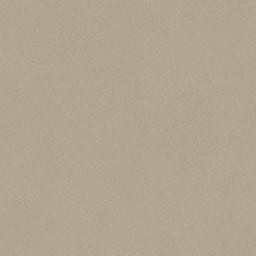

In [14]:
# Visualising an example
ipimage(desert_train + "/" + "desert(1007).jpg", width=200)

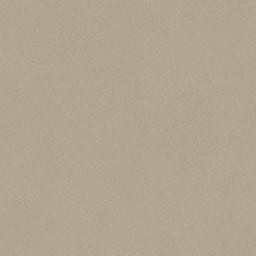

In [15]:
ipimage(desert_train + "/" + "desert(1007) (1).jpg", width=200)

In [16]:
# Double-checking with code
try:
    ipimage(desert_train + "/" + "desert(1007).jpg", width=200) == ipimage(desert_train + "/" + "desert(1007) (1).jpg", width=200)
except:
    print("Not the same")
else:
    print("The same")

The same


In [ ]:
# Disposing of spaces in names and standardizing name format
pattern_s = r"\s\(\d+\)" # regex writtern with the help of ChatGPT

# Dirs to iterate on
list_paths_train = [cloudy_train, desert_train, forest_train, water_train]

# Iterating on each path
for the_dir in list_paths_train:
    # Iterating for each filename in the dataframe 
    for filename in image_df.img_name:
        # File directory
        the_file = the_dir + "/" + filename
        # Checking first if file directory exists
        if os.path.exists(the_file):
            # If exists check if pattern matches
            match = re.search(pattern_s, filename)
            if match:
                # Remove image from dir
                os.remove(the_file)
                # Remove its record from image_df
                image_df = image_df.drop(image_df.loc[image_df["img_name"] == filename].index)
            elif not match:
                # If image is no duplicate, just standardize its name
                new_filename = filename.replace("(", "_", 1).replace("(", "").replace(")", "").lower()
                os.rename(os.path.join(the_dir + "/" + filename), (the_dir + "/" + new_filename))
        # If path doesn't exist, i.e. file is in different path
        else:
            continue

In [ ]:
# Applying name standardization to the df as well
for column in image_df.columns:
    image_df[column] = image_df[column].apply(lambda x : str(x).replace("(", "_", 1).replace("(", "").replace(")", "").lower())

# Shuffling the dataframe
image_df = image_df.sample(frac = 1).reset_index(drop = True)

Before moving on to potential changes in the folders, let's make sure we know the min and max image sizes, in case resizing needs to occur

In [19]:
# Since the names of the files have changed, the lists of files must adapt accordingly
cloudy_img_lst = os.listdir(cloudy_train)
desert_img_lst = os.listdir(desert_train)
forest_img_lst = os.listdir(forest_train)
water_img_lst = os.listdir(water_train)

# Tuples are highly convenient, as they allow for targeting only specific folders during iterations, instead of going over all potential 
# directories with conditionals to find out whether they exist or not
cloudy_siz_tup = cloudy_train, cloudy_img_lst
desert_siz_tup = desert_train, desert_img_lst
forest_siz_tup = forest_train, forest_img_lst
water_siz_tup = water_train, water_img_lst


# List to store dimensions of images
size_list = []

# Iterating on tuple list
for pair in [cloudy_siz_tup, desert_siz_tup, forest_siz_tup, water_siz_tup]:
    # Iterating on image list
    for filename in pair[1]:
        # Getting item from path using second item in tuple
        img_get = Image.open(pair[0] + "/" + filename)
        # Storing image size
        img_size = img_get.size
        size_list.append(img_size)

# Storing max and min sizes 
res_max = list(map(max, zip(*size_list)))
res_min = list(map(min, zip(*size_list)))

print("Maximum image size:", res_max)
print("Minimum image size:", res_min)

Maximum image size: [256, 256]
Minimum image size: [64, 64]


In [ ]:
image_df.to_csv("data/image_df.csv", index=0)

# <a id="4"><font color = "lightseagreen">4. Addressing Data Imbalance<font></a>

In [22]:
image_df["img_class"].value_counts()

cloudy    1500
water     1500
forest    1500
desert    1092
Name: img_class, dtype: int64

<font color = "dimgray">The desert class was already under-represented, but after the removal of duplicate images, it  became even more so.<font>

<font color = "dimgray">2 directories will be used. One for the baseline model using the imbalanced data and one for the model using the balanced data.<font>

In [ ]:
# Creating path
data_balance = os.path.join(os.getcwd(), "data_balance")

# Copying data
dest = shutil.copytree(data_path, data_balance)

# Checking that tree has been copied
print(os.listdir(data_balance))

# here, image_df.csv was also copied but can easily just be deleted manually

In [ ]:
# Defining new paths for the image folders
cloudy_btrain = os.path.join(data_balance, "train/cloudy")
desert_btrain = os.path.join(data_balance, "train/desert")
forest_btrain = os.path.join(data_balance, "train/green_area")
water_btrain = os.path.join(data_balance, "train/water")

# Defining new validation directories to be created
cloudy_bvalid = os.path.join(data_balance, "valid/cloudy")
desert_bvalid = os.path.join(data_balance, "valid/desert")
forest_bvalid = os.path.join(data_balance, "valid/green_area")
water_bvalid = os.path.join(data_balance, "valid/water")

# Defining new test directory to be created
balanced_test_dir = os.path.join(data_balance, "test/test")

# Fixing them up so they don't get overwritten
fix_valid_test_dirs([cloudy_bvalid, desert_bvalid, forest_bvalid, water_bvalid], balanced_test_dir)

In [ ]:
# Balancing the data in this case can easily be done by limiting the number of files to process
# from the over-represented classes to that of the under-represented one
# A simple way to do that is to sample the data using image_df
sample_cloudy = image_df[image_df["img_class"]=="cloudy"].sample(1092)
sample_forest = image_df[image_df["img_class"]=="forest"].sample(1092)
sample_water = image_df[image_df["img_class"]=="water"].sample(1092)

In [ ]:
# Putting the collection together
balanced_df = pd.concat([sample_cloudy, sample_forest, sample_water, image_df[image_df["img_class"]=="desert"]], axis = 0).sample(frac = 1).reset_index(drop = True)
balanced_df.shape

In [48]:
balanced_df["img_class"].value_counts()

forest    1092
water     1092
desert    1092
cloudy    1092
Name: img_class, dtype: int64

In [8]:
balanced_df.to_csv("data_balance/balanced_df.csv", index = 0)

<font color = "dimgray">Images not present in the dataframe must be deleted.<font>

In [ ]:
# Lists of images in train folder
dir_bcloudy = os.listdir(cloudy_btrain)
dir_bdesert = os.listdir(desert_btrain)
dir_bgreen = os.listdir(forest_btrain)
dir_bwater = os.listdir(water_btrain)

In [ ]:
# Dirs to iterate on
paths_list = [cloudy_btrain, desert_btrain, forest_btrain, water_btrain]
folders = [dir_bcloudy, dir_bdesert, dir_bgreen, dir_bwater]

# Iterating on each folder dir
for i in range(0,len(folders)):
    folder = folders[i]
    path = paths_list[i]
    # Iterating on file in the folder
    for folder_filename in folder:
        # File directory
        the_file = path + "/" + folder_filename
        # Checking first if file directory exists
        if os.path.exists(the_file):
            # If exists in list
            if folder_filename in balanced_df.img_name.unique().tolist():
                # Keep image
                continue
            else:
                os.remove(the_file)
        # If path doesn't exist, i.e. file is in different path
        else:
            continue

# <a id="5"><font color = "lightseagreen">5. Train-validation-test split<font></a>

<font color = "dimgray">As with all operations up to now, any changes affecting the dataframe, which only serves as a mapping tool for the image dataset, will have to be reflected in the actual data. The next couple of functions will perform the required file operations.<font>

In [ ]:
# Function to sample images from the different classes
def names_per_class(df, class_column, name_column):
    # sorted list of classes
    class_list = df[class_column].unique()
    class_list.sort()
    # list to store lists
    nested_class_lists = []
    # storing lists in class_nested_lists
    for each_class in class_list:
        class_images = list(df[df[class_column]==each_class][name_column])
        nested_class_lists.append(class_images)
    
    return nested_class_lists

# Function to sample names following names_per_class() function
def name_sampler(nested_class_lists, percentage):
    # list to store samples
    nested_samples = []
    for each_list in nested_class_lists:
        random.seed(400)
        list_class_sample = sample(each_list, int(len(each_list) * percentage))
        nested_samples.append(list_class_sample)
    
    return nested_samples

# Function for moving images
def move_img(img_list, source, destination):
    for name in img_list:
        shutil.move(source + "/" + name, destination +  "/" + name)

In [ ]:
# Function to train-validation-test split
def homemade_split(df, class_column, name_column, valid_source_dest_tuple_list, test_dest, split_percent=.2): # setting default for overall splitting to validation/test sets to 20%
    
    # writing image names in lists
    nested_lists_fraction_1 = names_per_class(df, class_column, name_column)
    
    # storing random sample of the desired percentage of names of items in lists to be moved in validation folder in new lists
    name_samples = name_sampler(nested_lists_fraction_1, split_percent)
    
    split_name_list = []
    for name_sample in name_samples:
        # dividing name lists by 2 for validation-test sets
        valid_frac = name_sample[:int(len(name_sample)/2)]
        test_frac = name_sample[int(len(name_sample)/2):]
        # saving each pair of lists in a tuple for easy access
        name_sample_tup = valid_frac, test_frac
        # saving the 4 tuples in a new list
        split_name_list.append(name_sample_tup)
        
    # creating lists for validation and test sets by merging the 4 subsets
    valid_list_names = [*split_name_list[0][0], *split_name_list[1][0], *split_name_list[2][0], *split_name_list[3][0]]
    test_list_names = [*split_name_list[0][1], *split_name_list[1][1], *split_name_list[2][1], *split_name_list[3][1]]
    
    # deviding split dataframe sample by 2 for validation-test sets
    df_fraction_valid = df[df[name_column].isin(valid_list_names)]
    df_fraction_test = df[df[name_column].isin(test_list_names)]
    
    # this list will be used to subtract rows from training dataframe
    name_sample_mixed = [*name_samples[0], *name_samples[1], *name_samples[2], *name_samples[3]]
    
    # redefining train_df with remaining rows
    train_df = df[~df[name_column].isin(name_sample_mixed)].reset_index(drop=True)
    
    # writing image names in lists
    nested_name_lists_valid = names_per_class(df_fraction_valid, class_column, name_column)

    # creating tuples with (sample, source, destination) for validation data
    tuple_1 = nested_name_lists_valid[0], valid_source_dest_tuple_list[0][0], valid_source_dest_tuple_list[0][1]
    tuple_2 = nested_name_lists_valid[1], valid_source_dest_tuple_list[1][0], valid_source_dest_tuple_list[1][1]
    tuple_3 = nested_name_lists_valid[2], valid_source_dest_tuple_list[2][0], valid_source_dest_tuple_list[2][1]
    tuple_4 = nested_name_lists_valid[3], valid_source_dest_tuple_list[3][0], valid_source_dest_tuple_list[3][1]
    
    # preparation for following for loop
    tuples = [tuple_1, tuple_2, tuple_3, tuple_4]

    # moving to validation dirs
    for tuple_trio in tuples:
        move_img(tuple_trio[0], tuple_trio[1], tuple_trio[2])


    # repeating above steps for test folder
    nested_lists_test = names_per_class(df_fraction_test, class_column, name_column)
    
    # create source path list and name_list list
    source_path_list = [valid_source_dest_tuple_list[0][0], valid_source_dest_tuple_list[1][0], valid_source_dest_tuple_list[2][0], valid_source_dest_tuple_list[3][0]]
    
    # move files of test fraction to test folder
    i = 0
    for source_path in source_path_list:
        move_img(split_name_list[i][1], source_path, test_dest)
        i += 1

    
    return train_df, df_fraction_valid, df_fraction_test

<h3 style = "color:lightseagreen">- Imbalanced Set</h3>

In [ ]:
# (source, destination) tuples for imbalanced data
imb_cl_tuple = cloudy_train, cloudy_valid
imb_des_tuple = desert_train, desert_valid
imb_gr_tuple = forest_train, forest_valid
imb_wat_tuple = water_train, water_valid

imbalanced_tuple_list = [imb_cl_tuple, imb_des_tuple, imb_gr_tuple, imb_wat_tuple]

# Splitting imbalanced data
imbalanced_train, imbalanced_valid, imbalanced_test = homemade_split(image_df, "img_class", "img_name", imbalanced_tuple_list, imbalanced_test_dir)

In [35]:
print("Length of train set:", f"{'':<5}{len(imbalanced_train)}", "of which", "\n",  # Indentation trick found at https://stackoverflow.com/questions/18756510/printing-with-indentation-in-python
      f"{'':<25}{len(imbalanced_train[imbalanced_train['img_class']=='cloudy'])}", "cloudy", "\n",
         f"{'':<25}{len(imbalanced_train[imbalanced_train['img_class']=='desert'])}", "desert", "\n", 
         f"{'':<25}{len(imbalanced_train[imbalanced_train['img_class']=='forest'])}", "forest", "\n",
         f"{'':<25}{len(imbalanced_train[imbalanced_train['img_class']=='water'])}", "water")

print("Length of validation set:", len(imbalanced_valid["img_class"]), "of which", "\n",
      f"{'':<25}{len(imbalanced_valid[imbalanced_valid['img_class']=='cloudy'])}", "cloudy", "\n",
         f"{'':<25}{len(imbalanced_valid[imbalanced_valid['img_class']=='desert'])}", "desert", "\n", 
         f"{'':<25}{len(imbalanced_valid[imbalanced_valid['img_class']=='forest'])}", "forest", "\n",
         f"{'':<25}{len(imbalanced_valid[imbalanced_valid['img_class']=='water'])}", "water", "\n")

print("Length of test set:", f"{'':<6}{len(imbalanced_test)}", "mixed")

Length of train set:      4474 of which 
                          1200 cloudy 
                          874 desert 
                          1200 forest 
                          1200 water
Length of validation set: 559 of which 
                          150 cloudy 
                          109 desert 
                          150 forest 
                          150 water 

Length of test set:       559 mixed


<h3 style = "color:lightseagreen">- Balanced Set</h3>

In [ ]:
# (source, destination) tuples for balanced data
bal_cl_tuple = cloudy_btrain, cloudy_bvalid
bal_des_tuple = desert_btrain, desert_bvalid
bal_gr_tuple = forest_btrain, forest_bvalid
bal_wat_tuple = water_btrain, water_bvalid

balanced_tuple_list = [bal_cl_tuple, bal_des_tuple, bal_gr_tuple, bal_wat_tuple]

# Splitting balanced data
balanced_train, balanced_valid, balanced_test = homemade_split(balanced_df, "img_class", "img_name", balanced_tuple_list, balanced_test_dir)

In [53]:
print("Length of train set:", f"{'':<5}{len(balanced_test)}", "of which", "\n",
      f"{'':<25}{len(balanced_train[balanced_train['img_class']=='cloudy'])}", "cloudy", "\n",
         f"{'':<25}{len(balanced_train[balanced_train['img_class']=='desert'])}", "desert", "\n", 
         f"{'':<25}{len(balanced_train[balanced_train['img_class']=='forest'])}", "forest", "\n",
         f"{'':<25}{len(balanced_train[balanced_train['img_class']=='water'])}", "water")

print("Length of validation set:", len(balanced_valid), "of which", "\n",
      f"{'':<25}{len(balanced_valid[balanced_valid['img_class']=='cloudy'])}", "cloudy", "\n",
         f"{'':<25}{len(balanced_valid[balanced_valid['img_class']=='desert'])}", "desert", "\n", 
         f"{'':<25}{len(balanced_valid[balanced_valid['img_class']=='forest'])}", "forest", "\n",
         f"{'':<25}{len(balanced_valid[balanced_valid['img_class']=='water'])}", "water", "\n")

print("Length of test set:", f"{'':<6}{len(balanced_test)}", "mixed")

Length of train set:      436 of which 
                          874 cloudy 
                          874 desert 
                          874 forest 
                          874 water
Length of validation set: 436 of which 
                          109 cloudy 
                          109 desert 
                          109 forest 
                          109 water 

Length of test set:       436 mixed


<b>Note:</b> Now that everything has been set up, it is time for modeling. Please refer to the second notebook in this folder [TITLE](href) for the concluding chapters of this project.